In [1]:
import pandas as pd
import numpy as np
from pylab import *
import scipy.stats as stats
from scipy.stats import kurtosis
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
import shap
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [2]:
df= pd.read_pickle("../Data/Processed/clean_rows_df.pkl")  
df.head()

,VoltageCurve,CurrentCurve,spotName,TimeStamp
494,"[132, 744, 1299, 1663, 1894, 2002, 2068, 2110,...","[311, 1990, 3577, 4759, 5599, 6190, 6594, 6999...",60000_0_00,2019-11-07 12:29:06
2439,"[136, 752, 1308, 1675, 1923, 2068, 2128, 2180,...","[301, 1961, 3470, 4527, 5432, 6066, 6489, 6911...",60000_0_00,2019-11-07 12:29:26
2515,"[139, 757, 1292, 1655, 1885, 2042, 2099, 2099,...","[333, 2058, 3663, 4814, 5661, 6388, 6842, 7084...",60000_0_00,2019-11-07 12:29:26
2935,"[133, 743, 1286, 1645, 1887, 2046, 2104, 2104,...","[307, 2031, 3632, 4802, 5695, 6434, 6865, 7142...",60000_0_00,2019-11-07 12:29:30
3239,"[137, 755, 1313, 1683, 1906, 2043, 2147, 2189,...","[302, 1995, 3508, 4596, 5382, 5987, 6562, 6955...",60000_0_00,2019-11-07 12:29:32


In [3]:
df.reset_index(inplace=True)
df.set_index(["spotName","TimeStamp"],inplace=True)

# ML su Current Curve

In [4]:
exploded_current=pd.DataFrame(df.CurrentCurve.tolist(), index= df.index)

indice del primo valore per cui l'inclinazione della curva inizia a diventare negativa
Escludere i valori precedenti a questo indice per analizzare la curva

In [6]:
#indice del primo valore per cui l'inclinazione della curva diventa negativa
#position=curva.diff()[curva.diff()==next(x for x in curva.diff() if x < 0)].index[0]
#curva_new è la curva senza il primo picco
#curva_new=curva.iloc[position:]
#plot(curva_new)

In [5]:
exploded_current_diff=exploded_current.diff(axis=1)
exploded_current_diff=exploded_current_diff.drop(columns=0,axis=1)

In [6]:
exploded_current_diff.iloc[:3].apply(lambda x: x.gt(0).idxmin(),axis=1)

spotName    TimeStamp          
60000_0_00  2019-11-07 12:29:06    12
            2019-11-07 12:29:26     9
            2019-11-07 12:29:26    10
dtype: int64

In [7]:
exploded_current_diff["posizione"]=exploded_current_diff.apply(lambda x: x.gt(0).idxmin(),axis=1)

In [ ]:
#(exploded_current_diff.iloc[:3].apply(lambda x: x[x.posizione:],axis=1))

Non so come fare a rimuovere i primi n valori sulla base di posizione!!!!!

--> faccio una media di posizione arrotondata per eccesso e rimuovo le prime x=media(posizione) colonne del dataframe.

In [8]:
math.ceil(exploded_current_diff.posizione.mean())

11

In [9]:
curve_ML=exploded_current.iloc[: , math.ceil(exploded_current_diff.posizione.mean()):]

## Estrazione Caratteristiche curve Current
Calcolo le caratteristiche delle curve su cui poi applicare algoritmi di ML:
- Media, Max, Min, Range, Varianza, Derivata, Curtosi...

In [10]:
curve_ML["media"]=curve_ML.iloc[:,:616].apply(mean,axis=1)
curve_ML["mediana"]=curve_ML.iloc[:,:616].apply(lambda x : median(x[x.notna()]),axis=1)
curve_ML["max"]=curve_ML.iloc[:,:616].apply(max,axis=1)
curve_ML["min"]=curve_ML.iloc[:,:616].apply(min,axis=1)
curve_ML["varianza"]=curve_ML.iloc[:,:616].apply(var,axis=1)

In [11]:
curve_ML["mediana"]=curve_ML.iloc[:,:616].apply(lambda x : median(x[x.notna()]),axis=1)

In [12]:
#lunghezza come numero di valori non Null
curve_ML["lunghezza"]=curve_ML.iloc[:,:616].apply(lambda x: len(x[x.notna()]),axis=1)

In [13]:
#range intesa come max-min
curve_ML["range"]=curve_ML.iloc[:,:616].apply(lambda x: x.max()-x.min(),axis=1)

In [14]:
#calcolo della derivata come delta(y)/delta(x): ovvero range/lunghezza lista
curve_ML["derivata"]=curve_ML.apply(lambda x: x.range/len(x[:616][x[:616].notna()]),axis=1)

In [15]:
#curtosi
curve_ML["kurtosis"]=curve_ML.iloc[:,:616].apply(lambda x: kurtosis(x[x.notna()]),axis=1)

In [25]:
final_ML=curve_ML.iloc[:,613:]
final_ML.head()

media  mediana     max     min  \
spotName   TimeStamp                                                   
60000_0_00 2019-11-07 12:29:06  7514.265226   7528.0  7901.0  7217.0   
           2019-11-07 12:29:26  7529.075061   7575.0  7696.0  7153.0   
           2019-11-07 12:29:26  7565.614815   7599.0  7720.0  7327.0   
           2019-11-07 12:29:30  7631.377404   7696.0  7850.0  7235.0   
           2019-11-07 12:29:32  7535.650367   7560.0  7711.0  7227.0   

                                    varianza  lunghezza  range  derivata  \
spotName   TimeStamp                                                       
60000_0_00 2019-11-07 12:29:06   8319.688262        512  684.0  1.335938   
           2019-11-07 12:29:26  13759.477890        416  543.0  1.305288   
           2019-11-07 12:29:26   7377.801106        408  393.0  0.963235   
           2019-11-07 12:29:30  19714.391868        419  615.0  1.467780   
           2019-11-07 12:29:32  10733.617974        412  484.0  1.174757   

                                kurtosis  
spotName   TimeStamp                      
60000_0_00 2019-11-07 12:29:06  2.712159  
           2019-11-07 12:29:26  0.556375  
           2019-11-07 12:29:26  0.217216  
           2019-11-07 12:29:30 -0.354173  
           2019-11-07 12:29:32  0.240765

In [26]:
final_ML.to_pickle("../data/processed/current_ML.pkl")

## Feature Engineering

In [27]:
final_ML= pd.read_pickle("../data/processed/current_ML.pkl")

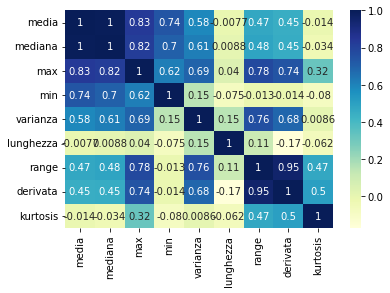

In [28]:
ax=sns.heatmap(final_ML.corr(),annot=True,cmap="YlGnBu")

dalla matrice di correlazione indica correlazioni più forti rispetto a quella delle curve di voltaggio, mediana e media hanno addirittura corr=1: ad indicare la maggior omogeneità dei processi analizzati

In [29]:
dummy=final_ML.drop(["media","range","max","min","varianza"],axis=1)

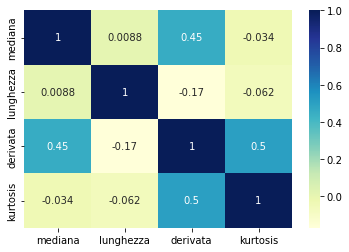

In [30]:
ax=sns.heatmap(dummy.corr(),annot=True,cmap="YlGnBu")

#### Split train & test set
Essendo un problema non supervisionato opero un random holdhout per la creazione di train e test set.

In [31]:
df_train, df_test=train_test_split(dummy,train_size=0.8,shuffle=True,random_state=0)

## Isolation Forest

In [32]:
iso = IsolationForest(contamination=0.1)
yhat_iForest = iso.fit_predict(df_train)

X does not have valid feature names, but IsolationForest was fitted with feature names


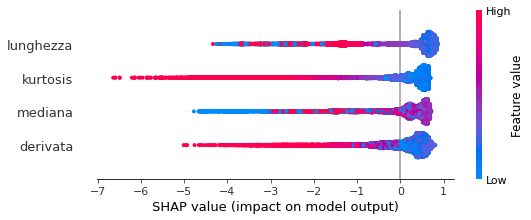

In [33]:
shap_values = shap.TreeExplainer(iso).shap_values(df_test)
shap.summary_plot(shap_values, df_test)

## Minimum Covariance Determinant

if the input variables have a Gaussian distribution, then simple statistical methods can be used to detect outliers. Check se distribuzione è gaussiana, metodo grafico e poi test di Shapiro-Wilk. La distribuzione non è gaussiana, p-value > 0.05, then we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian.

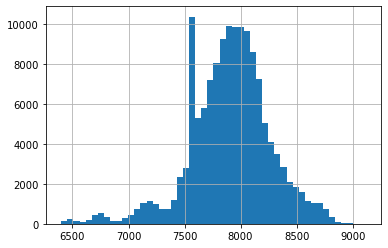

In [36]:
final_ML["media"].hist(bins=50);

In [37]:
from scipy.stats import normaltest

stat, p = normaltest(final_ML["media"])
print('stat=%.3f, p=%.3f\n' % (stat, p))

stat=10564.698, p=0.000



In [38]:
ee = EllipticEnvelope(contamination=0.01)
yhat__ee = ee.fit_predict(df_train)

## Local Outlier Factor

In [45]:
LOF = LocalOutlierFactor()
yhat_LOF = lof.fit_predict(df_train)

In [46]:
yhat_LOF

array([1, 1, 1, ..., 1, 1, 1])

## One-Class Support Vector Machine 

In [54]:
ee = OneClassSVM(nu=0.01)
yhat_SVM = ee.fit_predict(df_train)

## Aggiungo colonne delle varie yhat al df

In [38]:
len(df_train)

113336

In [40]:
df_train["iForest"]=yhat_iForest

In [47]:
df_train["LOF"]=yhat_LOF

In [55]:
df_train["SVM"]=yhat_SVM

In [41]:
df_train[df_train["iForest"]==-1]

,,mediana,lunghezza,derivata,kurtosis,iForest
spotName,TimeStamp,,,,,
60028_0_00,2020-01-09 10:23:49,7176.0,564,1.953901,2.988510,-1
60061_0_00,2020-01-14 13:06:07,7980.0,396,3.664141,27.120973,-1
60049_0_00,2019-09-23 07:20:22,7943.0,397,5.644836,30.379567,-1
60169_0_00,2019-12-10 19:25:45,8041.0,296,2.935811,13.988969,-1
60049_0_00,2019-12-03 11:43:31,8314.0,399,4.897243,8.781956,-1
...,...,...,...,...,...,...
60055_0_00,2020-02-25 14:29:52,7991.0,405,4.790123,12.529585,-1
60088_0_00,2019-11-27 12:53:33,6567.0,432,1.532407,1.319230,-1
60061_0_00,2020-03-04 11:07:28,8182.0,400,5.332500,30.790926,-1


## Plot per valutare curve anomale
Le curve anomale rilevate sembrerebbero essere quelle con i cali anomali, sia attraverso drop repentini che cali più graduali ma precoci rispetto alla media

***L'algoritmo di ML avrà un bias per i cali rispetto ai picchi poichè i cali repentini rappresentano l'anomalia più evidente e diffusa del processo !!***

I processi con i cali più graduali spesso non vengono identificati da anomaly_drop ma sono caratterizzati da un alto valore di %volt_anomalies

In [ ]:
df.CurrentCurve

In [ ]:
60061_0_00	2020-01-14 13:06:07

In [ ]:
df= pd.read_pickle("../data/with_stat_anomalies.pkl")  

In [42]:
df.loc[('60028_0_00', '2020-01-09 10:23:49'), :]

indexing past lexsort depth may impact performance.


,index,VoltageCurve,CurrentCurve
TimeStamp,,,
2020-01-09 10:23:49,97219,"[117, 666, 1168, 1505, 1717, 1874, 1968, 1999,...","[268, 1697, 3037, 4020, 4704, 5300, 5806, 6074..."


indexing past lexsort depth may impact performance.


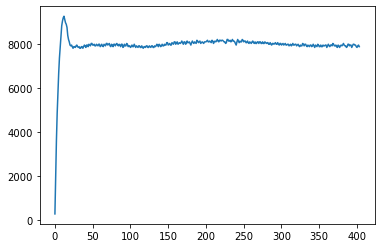

In [47]:
curva=df.loc[('60061_0_00', '2020-01-14 13:06:07'), :].CurrentCurve
plot(curva.values[0])